In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
from itertools import product 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer

In [2]:
data=pd.read_csv('E:/bit coin stream proccessing/BTC_7d_graph_coinmarketcap.csv',sep=';')
data_test=pd.read_csv('E:/bit coin stream proccessing/BTC_7d_graph_coinmarketcap (1).csv',sep=';')

In [3]:
data

,name,open,high,low,close,volume,marketCap,timestamp
0,2781,96835.813682,97105.004505,96824.939360,97024.776969,3.265635e+10,1.919951e+12,2024-11-30T18:00:00.000Z
1,2781,97020.586035,97046.299365,96374.734835,96449.055813,3.163423e+10,1.908653e+12,2024-11-30T21:00:00.000Z
2,2781,96461.336800,96707.025337,95770.184465,95779.223686,3.263064e+10,1.895564e+12,2024-12-01T00:00:00.000Z
3,2781,95774.250445,96540.745443,95771.207891,96384.891896,3.237334e+10,1.907347e+12,2024-12-01T03:00:00.000Z
4,2781,96369.367678,97213.016915,96358.051374,97101.463411,3.111905e+10,1.921454e+12,2024-12-01T06:00:00.000Z
5,2781,97101.451212,97178.031427,96642.008236,97173.488585,3.035687e+10,1.923029e+12,2024-12-01T09:00:00.000Z
6,2781,97172.450691,97456.118883,96747.789015,97352.553077,3.190203e+10,1.926599e+12,2024-12-01T12:00:00.000Z
7,2781,97352.511145,97409.848129,97060.565664,97360.592608,3.265275e+10,1.926991e+12,2024-12-01T15:00:00.000Z
8,2781,97359.095995,97575.838734,96886.434050,97132.007499,3.422169e+10,1.922075e+12,2024-12-01T18:00:00.000Z
9,2781,97125.117538,97888.127270,97112.017628,97279.792922,3.659070e+10,1.924785e+12,2024-12-01T21:00:00.000Z


In [4]:
# Parameters
train_window = 48       # 6 days * 8 (3-hour intervals per day) => 75% of 64 data points
test_window = 8         # Remaining 25% for testing
n_lags = 13              # Number of lags for defining lags

# Prepare the training and testing data
train_test_data_low = data['low']
train_test_data_high = data['high']

# Creating dictionaries to store lags
xy_train_test_low = {f'lag_{i}': [] for i in range(n_lags)}
xy_train_test_high = {f'lag_{i}': [] for i in range(n_lags)}

# Defining lags for 'low' and 'high' prices
for j in range(n_lags - 1, len(train_test_data_low)):
    for i in range(n_lags):
        xy_train_test_low[f'lag_{i}'].append(train_test_data_low[j - i])
        xy_train_test_high[f'lag_{i}'].append(train_test_data_high[j - i])

# Convert dictionaries to DataFrames
xy_train_test_low = pd.DataFrame(xy_train_test_low)
xy_train_test_high = pd.DataFrame(xy_train_test_high)

# Split into training and testing datasets
xy_train_low = xy_train_test_low[:-test_window]
xy_test_low = xy_train_test_low[-test_window:]

xy_train_high = xy_train_test_high[:-test_window]
xy_test_high = xy_train_test_high[-test_window:]

# Separate target (lag_0) and features (remaining lags)
y_train_low = xy_train_low['lag_0']
x_train_low = xy_train_low.iloc[:, 1:]

y_test_low = xy_test_low['lag_0']
x_test_low = xy_test_low.iloc[:, 1:]

y_train_high = xy_train_high['lag_0']
x_train_high = xy_train_high.iloc[:, 1:]

y_test_high = xy_test_high['lag_0']
x_test_high = xy_test_high.iloc[:, 1:]

# Display shapes to verify
print("x_train_low shape:", x_train_low.shape)
print("y_train_low shape:", y_train_low.shape)
print("x_test_low shape:", x_test_low.shape)
print("y_test_low shape:", y_test_low.shape)

print("x_train_high shape:", x_train_high.shape)
print("y_train_high shape:", y_train_high.shape)
print("x_test_high shape:", x_test_high.shape)
print("y_test_high shape:", y_test_high.shape)


x_train_low shape: (36, 12)
y_train_low shape: (36,)
x_test_low shape: (8, 12)
y_test_low shape: (8,)
x_train_high shape: (36, 12)
y_train_high shape: (36,)
x_test_high shape: (8, 12)
y_test_high shape: (8,)


In [5]:


# Define the log transformation function
log_transformer = FunctionTransformer(np.log1p, validate=True)

# Grid Search Parameters
param_grid = {
    'model__n_estimators': [50, 100, 150, 200],
    'model__learning_rate': [0.01, 0.1, 0.3, 0.5],
    'model__max_depth': [1, 3, 4, 5],
    'model__subsample': [0.6, 0.7, 0.8, 0.9],
    'model__min_child_weight': [3, 5],
    'model__gamma': [0.1, 0.5],
    'model__reg_lambda': [1, 10],
    'model__colsample_bytree': [0.7, 0.85],
    'model__reg_alpha': [0.1, 0.5]
}

# Total iterations for logging
total_iterations = np.prod([len(values) for values in param_grid.values()])
print(f"Total Grid Search Iterations: {total_iterations}")

# Best model tracking variables
best_low_model = None
best_low_params = None
best_low_r2_score = float('-inf')
r2_score_train_best= float('-inf')
r2_score_test_best= float('-inf')

# Counter for progress tracking
iteration = 0

# Define the pipeline
pipeline = Pipeline([
    ('log', log_transformer),
    ('scaler', MinMaxScaler()),
    ('model', XGBRegressor(objective='reg:absoluteerror'))
])

# Iterate over all combinations of hyperparameters in the grid
for params in product(*param_grid.values()):
    # Set the current parameters
    param_dict = dict(zip(param_grid.keys(), params))
    pipeline.set_params(**param_dict)

    # Fit the model
    pipeline.fit(x_train_low, y_train_low)

    # Predict on the test and train sets
    y_pred_low_test = pipeline.predict(x_test_low)
    y_pred_low_train = pipeline.predict(x_train_low)

    # Calculate R² score
    r2_score_test = r2_score(y_test_low, y_pred_low_test)
    r2_score_train = r2_score(y_train_low, y_pred_low_train)
    combined_r2_score = (5 * r2_score_test + 2 * r2_score_train) / 7

    # Print progress every 500 iterations
    iteration += 1
    if iteration % 500 == 0:
        print(f"Iteration {iteration}/{total_iterations} - Current best R² Score: {best_low_r2_score:.4f} and test:{r2_score_test_best} train:{r2_score_train_best}")

    # Update best model if the current R² score is higher
    if combined_r2_score > best_low_r2_score:
        best_low_r2_score = combined_r2_score
        best_low_params = param_dict
        best_low_model = pipeline
        r2_score_test_best= r2_score_test
        r2_score_train_best=r2_score_train

# Print the best parameters and the best R² score
print("\nBest Low Model Parameters:")
print(best_low_params)
print(f"Best R² Score for Training Data: {r2_score(y_train_low, best_low_model.predict(x_train_low)):.4f}")
print(f"Best R² Score for Test Data: {best_low_r2_score:.4f}")


Total Grid Search Iterations: 8192
Iteration 500/8192 - Current best R² Score: -20.8934 and test:-29.35409121385877 train:0.2584144050653281
Iteration 1000/8192 - Current best R² Score: 0.5010 and test:0.3900231831991745 train:0.7784917012677046
Iteration 1500/8192 - Current best R² Score: 0.7274 and test:0.6578083259873275 train:0.9012821252076871
Iteration 2000/8192 - Current best R² Score: 0.7536 and test:0.7355049449049198 train:0.7989106092862136
Iteration 2500/8192 - Current best R² Score: 0.7536 and test:0.7355049449049198 train:0.7989106092862136
Iteration 3000/8192 - Current best R² Score: 0.7536 and test:0.7355049449049198 train:0.7989106092862136
Iteration 3500/8192 - Current best R² Score: 0.7536 and test:0.7355049449049198 train:0.7989106092862136
Iteration 4000/8192 - Current best R² Score: 0.7536 and test:0.7355049449049198 train:0.7989106092862136
Iteration 4500/8192 - Current best R² Score: 0.7536 and test:0.7355049449049198 train:0.7989106092862136
Iteration 5000/8192

[[ 99034.875       99172.43336582  99522.95046837  99222.08951323
   99030.88649219  99710.67966418  99288.00300788 100712.88013996
   98742.18618794  97629.03915572  97750.49449955  97820.48555761]]
Prediction 0: 99033.421875
99033.421875
[[ 99033.421875    99034.875       99172.43336582  99522.95046837
   99222.08951323  99030.88649219  99710.67966418  99288.00300788
  100712.88013996  98742.18618794  97629.03915572  97750.49449955]]
Prediction 1: 99033.421875
99033.421875
[[ 99033.421875    99033.421875    99034.875       99172.43336582
   99522.95046837  99222.08951323  99030.88649219  99710.67966418
   99288.00300788 100712.88013996  98742.18618794  97629.03915572]]
Prediction 2: 99033.421875
99033.421875
[[ 99033.421875    99033.421875    99033.421875    99034.875
   99172.43336582  99522.95046837  99222.08951323  99030.88649219
   99710.67966418  99288.00300788 100712.88013996  98742.18618794]]
Prediction 3: 99033.421875
99033.421875
[[ 99033.421875    99033.421875    99033.4218

C:\Users\Aidyn\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
C:\Users\Aidyn\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
C:\Users\Aidyn\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
C:\Users\Aidyn\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
C:\Users\Aidyn\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
C:\Users\Aidyn\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning

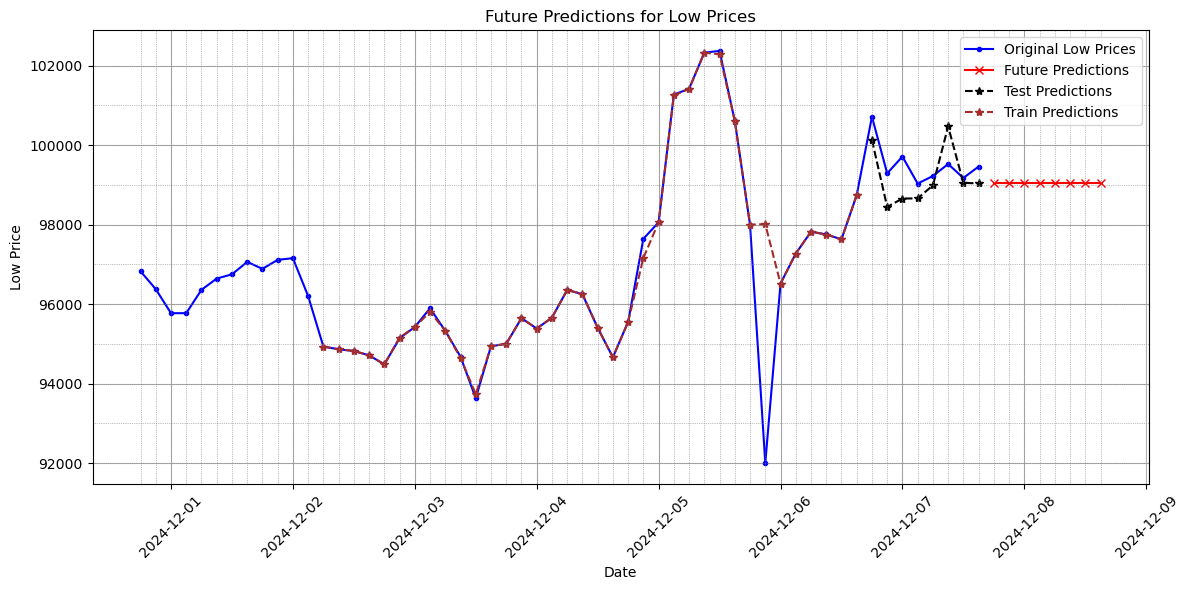

Train MAE: 191.01, Test MAE: 573.25


In [6]:
predictions = list(best_low_model.predict(x_test_low))

# Prepare last input for sequential future prediction
last_input = [predictions[-1]] + list(x_test_low.iloc[-1, 0:-1])
last_input = np.array(last_input).reshape(1, -1).copy()

# Number of future intervals to predict (8 future intervals)
future_intervals = 8

prediction=0
# Generate sequential predictions for the next 8 intervals
for i in range(future_intervals):
    
    
    print(last_input)


    # Predict the next low price
    prediction = best_low_model.predict(last_input.copy())[0].copy()
    print(f"Prediction {i}: {prediction}")
    predictions.append(prediction)

    # Update last_input by shifting right and inserting the new prediction
    last_input = np.roll(last_input, 1)
    last_input[0, 0] = prediction #+np.random.uniform(-1000, 1000)
    print(last_input[0, 0])


# Convert data timestamps to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Generate future timestamps
last_timestamp = data['timestamp'].iloc[-test_window]
future_dates = [last_timestamp + pd.Timedelta(hours=3 * i) for i in range(future_intervals + test_window)]

# Predict on training data
y_train_pre = best_low_model.predict(x_train_low)

# Generate timestamps for training predictions
first_timestamp = data['timestamp'].iloc[n_lags-1]
last_dates = [first_timestamp + pd.Timedelta(hours=3 * i) for i in range(train_window - n_lags + 1)]

# Create DataFrames for train predictions and future predictions
past_df = pd.DataFrame({'prices': y_train_pre, 'date': last_dates})
future_df = pd.DataFrame({'prices': predictions, 'date': future_dates})

# Split future predictions into test and future DataFrames
future_df_test = future_df[:test_window]
future_df_pre = future_df[-future_intervals:]

# Combine all timestamps for grid lines
all_dates = sorted(set(data['timestamp'].tolist() + future_df['date'].tolist() + past_df['date'].tolist()))

# Plot the original 'low' data and the future predictions
plt.figure(figsize=(12, 6))
plt.plot(data['timestamp'], data['low'], label='Original Low Prices', color='blue', marker='.')
plt.plot(future_df_pre['date'], future_df_pre['prices'], label='Future Predictions', color='red', linestyle='-', marker='x')
plt.plot(future_df_test['date'], future_df_test['prices'], label='Test Predictions', color='black', linestyle='--', marker='*')
plt.plot(past_df['date'], past_df['prices'], label='Train Predictions', color='brown', linestyle='--', marker='*')

# Add vertical grid lines for all dates
for date in all_dates:
    plt.axvline(date, color='gray', linestyle=':', linewidth=0.5)

# Add horizontal grid lines for price levels
for price in range(92000, 103000, 1000):
    plt.axhline(price, color='gray', linestyle=':', linewidth=0.5)

# Plot settings
plt.title('Future Predictions for Low Prices')
plt.xlabel('Date')
plt.ylabel('Low Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



train_mae = mean_absolute_error(y_train_low, best_low_model.predict(x_train_low))
test_mae = mean_absolute_error(y_test_low, best_low_model.predict(x_test_low))
print(f"Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")


0
Prediction 0: 99033.421875
99033.421875
99033.42
Prediction 1: 99033.421875
99033.421875
99033.42
Prediction 2: 99033.421875
99033.421875
99033.42
Prediction 3: 99033.421875
99033.421875
99033.42
Prediction 4: 99033.421875
99033.421875
99033.42
Prediction 5: 99033.421875
99033.421875
99033.42
Prediction 6: 99033.421875
99033.421875
99033.42
Prediction 7: 99033.421875
99033.421875
99033.42
Prediction 8: 99033.421875
99033.421875
99033.42
Prediction 9: 99033.421875
99033.421875
99033.42
Prediction 10: 99033.421875
99033.421875


C:\Users\Aidyn\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
C:\Users\Aidyn\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
C:\Users\Aidyn\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
C:\Users\Aidyn\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
C:\Users\Aidyn\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
C:\Users\Aidyn\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning

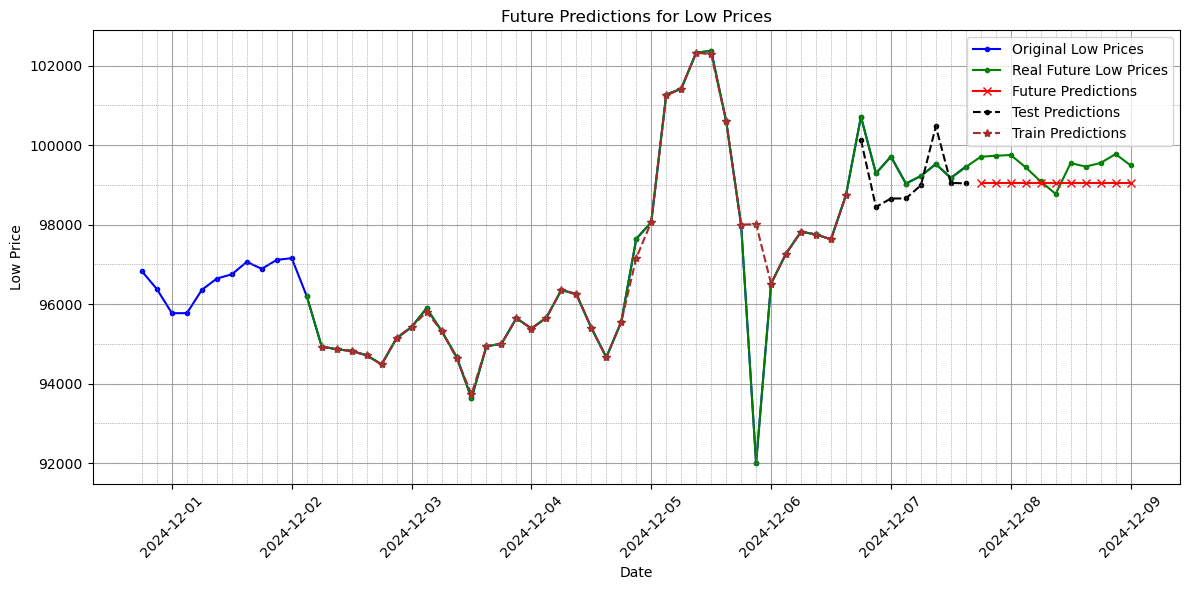

In [8]:

predictions = list(best_low_model.predict(x_test_low))

# Prepare last input for sequential future prediction
last_input = [predictions[-1]] + list(x_test_low.iloc[-1, 0:-1])
last_input = np.array(last_input).reshape(1, -1).copy()

# Number of future intervals to predict (8 train + 8 test + 3 unseen)
future_intervals = 8 + 3  

prediction=0
# Generate sequential predictions for the next 8 intervals
for i in range(future_intervals):


    print(prediction)


    # Predict the next low price
    prediction = best_low_model.predict(last_input.copy())[0].copy()
    print(f"Prediction {i}: {prediction}")
    predictions.append(prediction)

    # Update last_input by shifting right and inserting the new prediction
    last_input = np.roll(last_input, 1)
    last_input[0, 0] = prediction
    print(last_input[0, 0])
    
# Convert data timestamps to datetime
data_test['timestamp'] = pd.to_datetime(data_test['timestamp'])

# Generate future timestamps
last_timestamp = data['timestamp'].iloc[-test_window]
future_dates = [last_timestamp + pd.Timedelta(hours=3 * (i)) for i in range(future_intervals+ test_window)]

# Generate timestamps for the training predictions
first_timestamp = data['timestamp'].iloc[n_lags-1]
last_dates = [first_timestamp + pd.Timedelta(hours=3 * i) for i in range(train_window - n_lags + 1)]
y_train_pre = best_low_model.predict(x_train_low)
past_df = pd.DataFrame({'prices': y_train_pre, 'date': last_dates})

# Create DataFrame for predictions
future_df = pd.DataFrame({'prices': predictions, 'date': future_dates})

# Split predictions into test and unseen future data
future_df_test = future_df[:test_window]
future_df_pre = future_df[-future_intervals:]

# Combine all timestamps for unified grid lines
all_dates = sorted(
    set(data['timestamp'].tolist() + data_test['timestamp'].tolist() + future_df['date'].tolist() + past_df['date'].tolist())
)

# Convert data timestamps to datetime
data_test['timestamp'] = pd.to_datetime(data_test['timestamp'])

# Plot the original 'low' data and the future predictions
plt.figure(figsize=(12, 6))

plt.plot(data['timestamp'], data['low'], label='Original Low Prices', color='blue', marker='.')
plt.plot(data_test['timestamp'], data_test['low'], label='Real Future Low Prices', color='green', linestyle='-', marker='.')
plt.plot(future_df_pre['date'], future_df_pre['prices'], label='Future Predictions', color='red', linestyle='-', marker='x')
plt.plot(future_df_test['date'], future_df_test['prices'], label='Test Predictions', color='black', linestyle='--', marker='.')
plt.plot(past_df['date'], past_df['prices'], label='Train Predictions', color='brown', linestyle='--', marker='*')


# Add vertical grid lines for all dates
for date in all_dates:
    plt.axvline(date, color='gray', linestyle=':', linewidth=0.5)

# Add horizontal grid lines for price levels
for price in range(92000, 103000, 1000):  
    plt.axhline(price, color='gray', linestyle=':', linewidth=0.5)

plt.title('Future Predictions for Low Prices')
plt.xlabel('Date')
plt.ylabel('Low Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
# Calculate predicted and real minimum low prices
predicted_min_low = min(predictions[test_window:])
real_min_low = min(data_test['low'][data_test['timestamp'] > max(data['timestamp'])])
difference_low_min = predicted_min_low - real_min_low

print(f'Predicted lowest min is {predicted_min_low:.2f} USD')
print(f'Real lowest min is {real_min_low:.2f} USD')
print(f'Difference in min low is {difference_low_min:.2f} USD')



Predicted lowest min is 99033.42 USD
Real lowest min is 98771.51 USD
Difference in min low is 261.91 USD


In [10]:
# Concatenate training DataFrames column-wise
x_high_chained_train = pd.concat([x_train_high, x_train_low], axis=1)

x_high_chained_test = pd.concat([x_test_high, x_test_low], axis=1)

x_high_chained_test

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
36,101322.221879,99575.742035,98456.442900,98742.943976,98278.255159,98820.762284,99544.503018,101468.397914,103583.912733,103565.882676,...,97750.494500,97820.485558,97269.353970,96514.876082,91998.781701,97993.969935,100605.209326,102367.922992,102325.557793,101414.436503
37,102039.881796,101322.221879,99575.742035,98456.442900,98742.943976,98278.255159,98820.762284,99544.503018,101468.397914,103583.912733,...,97629.039156,97750.494500,97820.485558,97269.353970,96514.876082,91998.781701,97993.969935,100605.209326,102367.922992,102325.557793
38,101606.734917,102039.881796,101322.221879,99575.742035,98456.442900,98742.943976,98278.255159,98820.762284,99544.503018,101468.397914,...,98742.186188,97629.039156,97750.494500,97820.485558,97269.353970,96514.876082,91998.781701,97993.969935,100605.209326,102367.922992
39,100563.379751,101606.734917,102039.881796,101322.221879,99575.742035,98456.442900,98742.943976,98278.255159,98820.762284,99544.503018,...,100712.880140,98742.186188,97629.039156,97750.494500,97820.485558,97269.353970,96514.876082,91998.781701,97993.969935,100605.209326
40,100109.444509,100563.379751,101606.734917,102039.881796,101322.221879,99575.742035,98456.442900,98742.943976,98278.255159,98820.762284,...,99288.003008,100712.880140,98742.186188,97629.039156,97750.494500,97820.485558,97269.353970,96514.876082,91998.781701,97993.969935
41,99683.398664,100109.444509,100563.379751,101606.734917,102039.881796,101322.221879,99575.742035,98456.442900,98742.943976,98278.255159,...,99710.679664,99288.003008,100712.880140,98742.186188,97629.039156,97750.494500,97820.485558,97269.353970,96514.876082,91998.781701
42,99923.318300,99683.398664,100109.444509,100563.379751,101606.734917,102039.881796,101322.221879,99575.742035,98456.442900,98742.943976,...,99030.886492,99710.679664,99288.003008,100712.880140,98742.186188,97629.039156,97750.494500,97820.485558,97269.353970,96514.876082
43,99847.253918,99923.318300,99683.398664,100109.444509,100563.379751,101606.734917,102039.881796,101322.221879,99575.742035,98456.442900,...,99222.089513,99030.886492,99710.679664,99288.003008,100712.880140,98742.186188,97629.039156,97750.494500,97820.485558,97269.353970


In [19]:
# Define the log transformation function
log_transformer = FunctionTransformer(np.log1p, validate=True)

# Define the pipeline
pipeline = Pipeline([
    ('log', log_transformer),
    ('scaler', MinMaxScaler()),
    ('model', XGBRegressor(objective='reg:absoluteerror'))
])

# Grid Search Parameters
param_grid = {
    'model__n_estimators': [50, 100, 150, 200],
    'model__learning_rate': [0.01, 0.1, 0.3, 0.5],
    'model__max_depth': [1, 3, 4, 5],
    'model__subsample': [0.6, 0.7, 0.8, 0.9],
    'model__min_child_weight': [3, 5],
    'model__gamma': [0.1, 0.5],
    'model__reg_lambda': [1, 10],
    'model__colsample_bytree': [0.7, 0.85],
    'model__reg_alpha': [0.1, 0.5]
}

# Number of total iterations for logging purposes
total_iterations = np.prod([len(values) for values in param_grid.values()])
print(f"Total Grid Search Iterations: {total_iterations}")

# Best model tracking variables
best_high_chained_model = None
best_high_chained_params = None
best_combined_r2_score = float('-inf')
r2_score_test_best = float('-inf')
r2_score_train_best = float('-inf')

# Counter for progress tracking
iteration = 0

# Iterate over all combinations of hyperparameters in the grid
for params in product(*param_grid.values()):
    # Set the current parameters
    param_dict = dict(zip(param_grid.keys(), params))
    pipeline.set_params(**param_dict)

    # Fit the model
    pipeline.fit(x_high_chained_train, y_train_high)

    # Predict on the train and test sets
    y_pred_high_train = pipeline.predict(x_high_chained_train)
    y_pred_high_test = pipeline.predict(x_high_chained_test)

    # Calculate R² scores for train and test sets
    r2_score_test = r2_score(y_test_high, y_pred_high_test)
    r2_score_train = r2_score(y_train_high, y_pred_high_train)
    combined_r2_score = (5 * r2_score_test + 2 * r2_score_train) / 7

    # Print progress every 100 iterations
    iteration += 1
    if iteration % 1000 == 0:
        print(f"Iteration {iteration}/{total_iterations} - Current best Combined R² Score: {best_combined_r2_score:.4f} "
              f"(Test: {r2_score_test_best:.4f}, Train: {r2_score_train_best:.4f})")

    # Update best model if the current combined R² score is higher
    if combined_r2_score > best_combined_r2_score:
        best_combined_r2_score = combined_r2_score
        r2_score_test_best = r2_score_test
        r2_score_train_best = r2_score_train
        best_high_chained_params = param_dict
        best_high_chained_model = pipeline

# Print the best parameters and the best metrics
print("\nBest High Chained Model Parameters:")
print(best_high_chained_params)
print(f"Best Combined R² Score: {best_combined_r2_score:.4f}")
print(f"Best R² Score for Training Data: {r2_score_train_best:.4f}")
print(f"Best R² Score for Test Data: {r2_score_test_best:.4f}")



Total Grid Search Iterations: 8192
Iteration 1000/8192 - Current best Combined R² Score: 0.4443 (Test: 0.2383, Train: 0.9593)
Iteration 2000/8192 - Current best Combined R² Score: 0.7400 (Test: 0.6380, Train: 0.9948)
Iteration 3000/8192 - Current best Combined R² Score: 0.7400 (Test: 0.6380, Train: 0.9948)
Iteration 4000/8192 - Current best Combined R² Score: 0.7400 (Test: 0.6380, Train: 0.9948)
Iteration 5000/8192 - Current best Combined R² Score: 0.7400 (Test: 0.6380, Train: 0.9948)
Iteration 6000/8192 - Current best Combined R² Score: 0.7400 (Test: 0.6380, Train: 0.9948)
Iteration 7000/8192 - Current best Combined R² Score: 0.7400 (Test: 0.6380, Train: 0.9948)
Iteration 8000/8192 - Current best Combined R² Score: 0.7400 (Test: 0.6380, Train: 0.9948)

Best High Chained Model Parameters:
{'model__n_estimators': 50, 'model__learning_rate': 0.3, 'model__max_depth': 5, 'model__subsample': 0.7, 'model__min_child_weight': 3, 'model__gamma': 0.1, 'model__reg_lambda': 1, 'model__colsample_by

C:\Users\Aidyn\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
C:\Users\Aidyn\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
C:\Users\Aidyn\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
C:\Users\Aidyn\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
C:\Users\Aidyn\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
C:\Users\Aidyn\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning

101827.39
101848.83
101847.25
101847.25
101840.8
101840.8
101213.8
101192.36


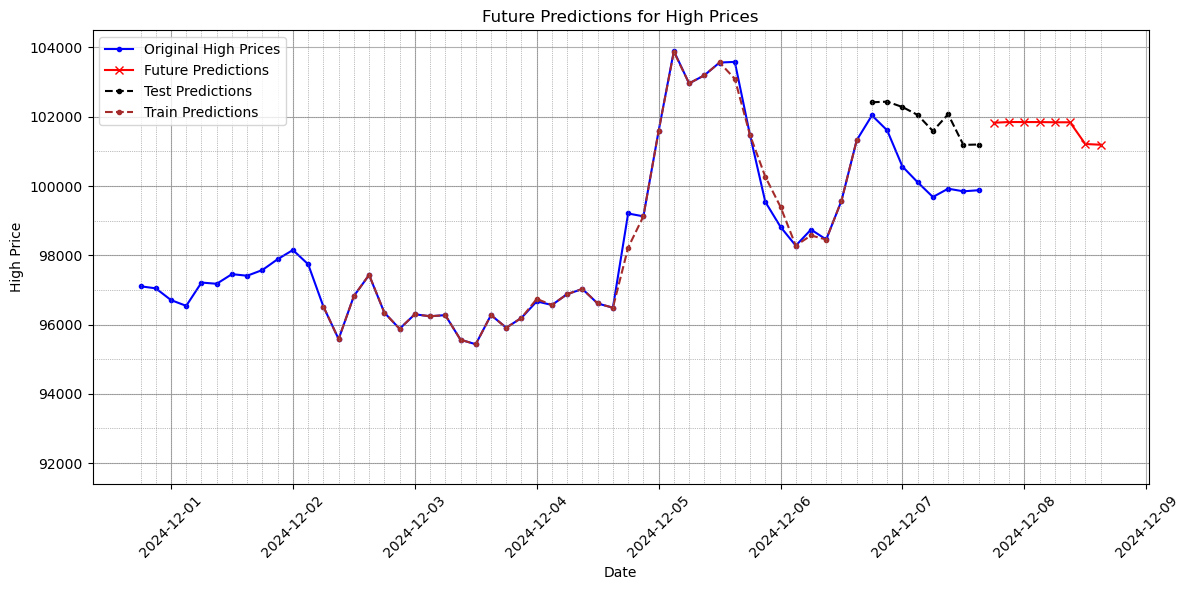

In [28]:
# Number of future intervals to predict (8 train + 4 test)
future_intervals = 8 

predictions_chained_high = list(best_high_chained_model.predict(x_high_chained_test))

# Prepare last input for sequential future prediction
last_input = [predictions_chained_high[-1]] + list(x_high_chained_test.iloc[-1, 0:-1])
last_input[n_lags-1] = predictions[test_window-1]

last_input = np.array(last_input).reshape(1, -1).copy()


# Generate sequential inputs for the next 12 intervals
for i in range(future_intervals):

    # Predict the next high price
    prediction_high = best_high_chained_model.predict(last_input)[0]
    predictions_chained_high.append(prediction_high)
    print(prediction_high)

    # Update last_input by shifting right and inserting the new high price prediction
    last_input = np.roll(last_input, 1)
    last_input[0, 0] = prediction_high
    last_input[0, n_lags-1]= predictions[test_window+i]

# Convert data timestamps to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Generate future timestamps
last_timestamp = data['timestamp'].iloc[-test_window]
future_dates = [last_timestamp + pd.Timedelta(hours=3 * i) for i in range(future_intervals+test_window)]

# Generate timestamps for the training predictions
first_timestamp = data['timestamp'].iloc[n_lags-1]
last_dates = [first_timestamp + pd.Timedelta(hours=3 * i) for i in range(train_window - n_lags + 1)]
y_train_pre_high = best_high_chained_model.predict(x_high_chained_train)
past_df_high = pd.DataFrame({'prices': y_train_pre_high, 'date': last_dates})

# Create DataFrame for predictions
future_df_high = pd.DataFrame({'prices': predictions_chained_high, 'date': future_dates})

# Split predictions into test and unseen future data
future_df_test_high = future_df_high[:test_window]
future_df_pre_high = future_df_high[test_window:]

# Combine all timestamps for unified grid lines
all_dates = sorted(
    set(data['timestamp'].tolist() + future_df_high['date'].tolist() + past_df_high['date'].tolist())
)

# Plot the original 'high' data and the future predictions
plt.figure(figsize=(12, 6))
plt.plot(data['timestamp'], data['high'], label='Original High Prices', color='blue', marker='.')
plt.plot(future_df_pre_high['date'], future_df_pre_high['prices'], label='Future Predictions', color='red', linestyle='-', marker='x')
plt.plot(future_df_test_high['date'], future_df_test_high['prices'], label='Test Predictions', color='black', linestyle='--', marker='.')
plt.plot(past_df_high['date'], past_df_high['prices'], label='Train Predictions', color='brown', linestyle='--', marker='.')

# Add vertical grid lines for all dates
for date in all_dates:
    plt.axvline(date, color='gray', linestyle=':', linewidth=0.5)

# Add horizontal grid lines for price levels
for price in range(92000, 103000, 1000):
    plt.axhline(price, color='gray', linestyle=':', linewidth=0.5)

plt.title('Future Predictions for High Prices')
plt.xlabel('Date')
plt.ylabel('High Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\Aidyn\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
C:\Users\Aidyn\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
C:\Users\Aidyn\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
C:\Users\Aidyn\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
C:\Users\Aidyn\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
C:\Users\Aidyn\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning

101827.39
101848.83
101847.25
101847.25
101840.8
101840.8
101213.8
101192.36
101193.94
101193.94
101200.39


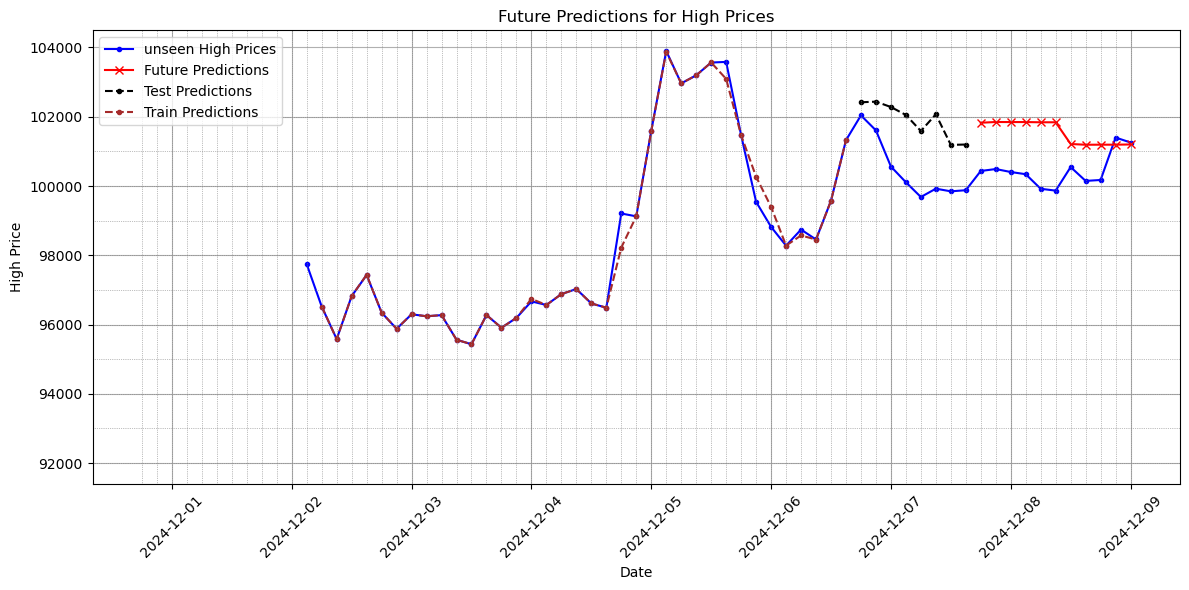

In [31]:
# Number of future intervals to predict (8 train + 4 test)
future_intervals = 8 +3

predictions_chained_high = list(best_high_chained_model.predict(x_high_chained_test))

# Prepare last input for sequential future prediction
last_input = [predictions_chained_high[-1]] + list(x_high_chained_test.iloc[-1, 0:-1])
last_input[n_lags-1] = predictions[test_window-1]

last_input = np.array(last_input).reshape(1, -1).copy()

# Generate sequential inputs for the next 12 intervals
for i in range(future_intervals):

    # Predict the next high price
    prediction_high = best_high_chained_model.predict(last_input)[0]
    predictions_chained_high.append(prediction_high)
    print(prediction_high)

    # Update last_input by shifting right and inserting the new high price prediction
    last_input = np.roll(last_input, 1)
    last_input[0, 0] = prediction_high
    last_input[0, n_lags-1]= predictions[test_window+i]

# Convert data timestamps to datetime
data_test['timestamp'] = pd.to_datetime(data_test['timestamp'])

# Generate future timestamps
last_timestamp = data['timestamp'].iloc[-test_window]
future_dates = [last_timestamp + pd.Timedelta(hours=3 * i) for i in range(future_intervals+test_window)]

# Generate timestamps for the training predictions
first_timestamp = data['timestamp'].iloc[n_lags-1]
last_dates = [first_timestamp + pd.Timedelta(hours=3 * i) for i in range(train_window - n_lags + 1)]
y_train_pre_high = best_high_chained_model.predict(x_high_chained_train)
past_df_high = pd.DataFrame({'prices': y_train_pre_high, 'date': last_dates})

# Create DataFrame for predictions
future_df_high = pd.DataFrame({'prices': predictions_chained_high, 'date': future_dates})

# Split predictions into test and unseen future data
future_df_test_high = future_df_high[:test_window]
future_df_pre_high = future_df_high[test_window:]

# Combine all timestamps for unified grid lines
all_dates = sorted(
    set(data['timestamp'].tolist() + data_test['timestamp'].tolist() + future_df['date'].tolist() + past_df['date'].tolist())
)


# Plot the original 'high' data and the future predictions
plt.figure(figsize=(12, 6))
plt.plot(data_test['timestamp'], data_test['high'], label='unseen High Prices', color='blue', marker='.')
plt.plot(future_df_pre_high['date'], future_df_pre_high['prices'], label='Future Predictions', color='red', linestyle='-', marker='x')
plt.plot(future_df_test_high['date'], future_df_test_high['prices'], label='Test Predictions', color='black', linestyle='--', marker='.')
plt.plot(past_df_high['date'], past_df_high['prices'], label='Train Predictions', color='brown', linestyle='--', marker='.')

# Add vertical grid lines for all dates
for date in all_dates:
    plt.axvline(date, color='gray', linestyle=':', linewidth=0.5)

# Add horizontal grid lines for price levels
for price in range(92000, 103000, 1000):
    plt.axhline(price, color='gray', linestyle=':', linewidth=0.5)

plt.title('Future Predictions for High Prices')
plt.xlabel('Date')
plt.ylabel('High Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



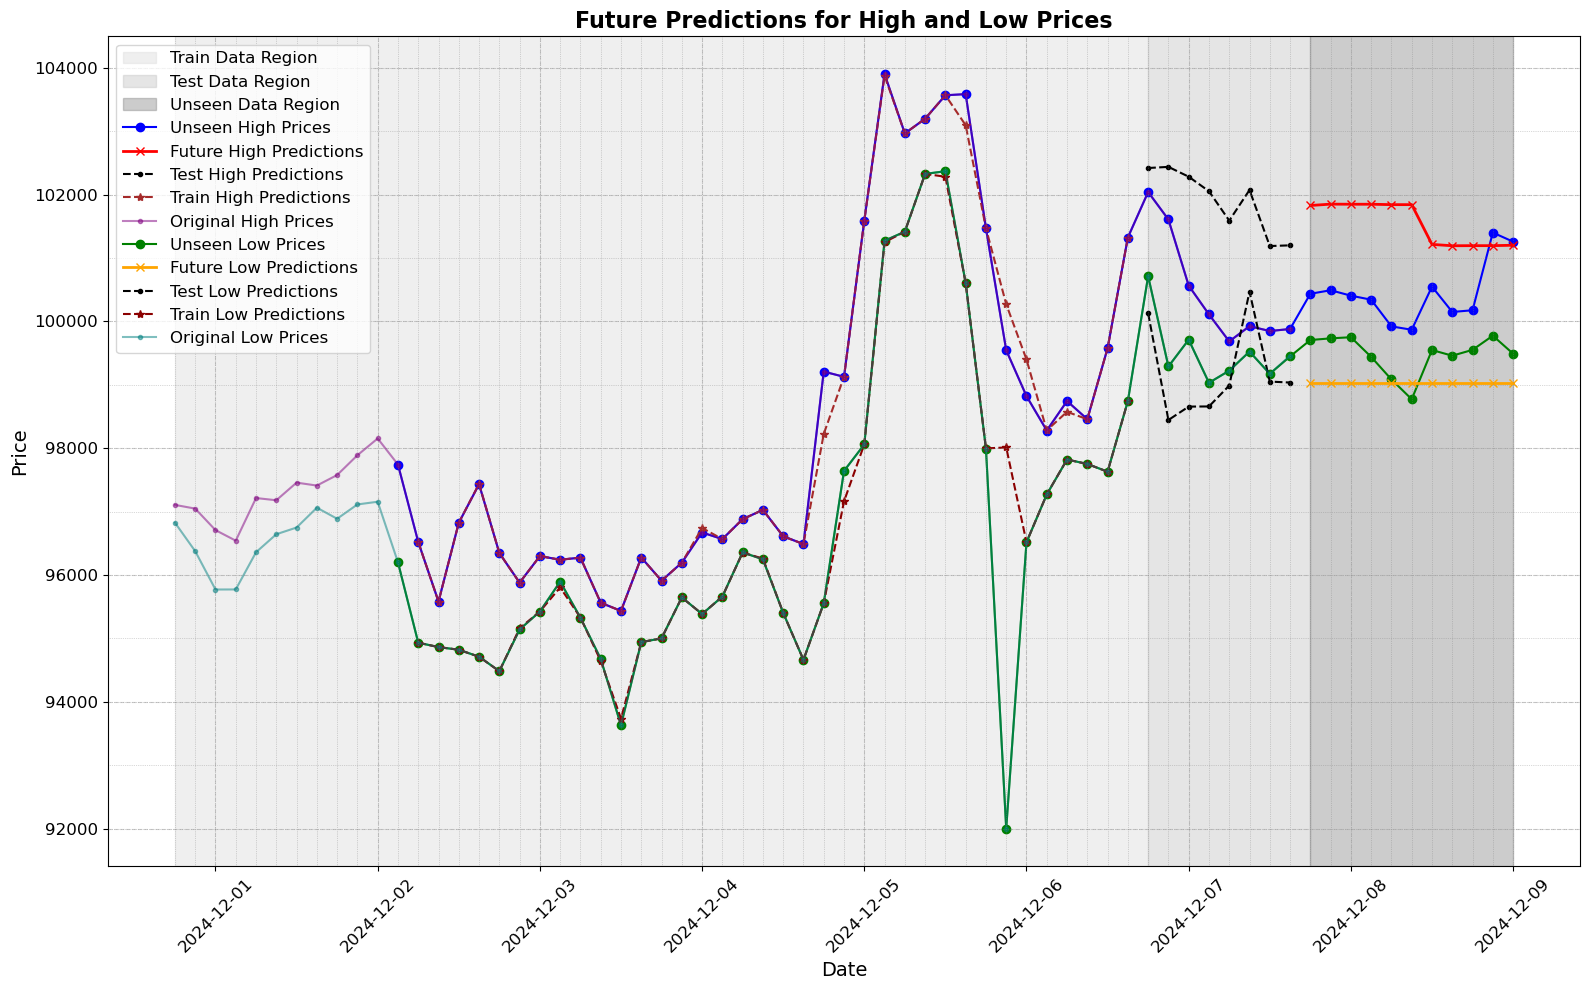

In [43]:
plt.figure(figsize=(16, 10))

# Define the start and end of each data region
train_start = data['timestamp'].iloc[0]
train_end = data['timestamp'].iloc[-test_window]

test_start = future_df['date'].iloc[0]
test_end = future_df['date'].iloc[test_window]

unseen_start = future_df['date'].iloc[test_window]
unseen_end = future_df['date'].iloc[-1]

# Shade the regions
plt.axvspan(train_start, train_end, color='#d9d9d9', alpha=0.4, label='Train Data Region')
plt.axvspan(test_start, test_end, color='#bfbfbf', alpha=0.4, label='Test Data Region')
plt.axvspan(unseen_start, unseen_end, color='gray', alpha=0.4, label='Unseen Data Region')

# Plot High Prices
plt.plot(data_test['timestamp'], data_test['high'], label='Unseen High Prices', color='blue', marker='o', linestyle='-', linewidth=1.5)
plt.plot(future_df_pre_high['date'], future_df_pre_high['prices'], label='Future High Predictions', color='red', marker='x', linestyle='-', linewidth=2)
plt.plot(future_df_test_high['date'], future_df_test_high['prices'], label='Test High Predictions', color='black', marker='.', linestyle='--', linewidth=1.5)
plt.plot(past_df_high['date'], past_df_high['prices'], label='Train High Predictions', color='brown', marker='*', linestyle='--', linewidth=1.5)
plt.plot(data['timestamp'], data['high'], label='Original High Prices', color='purple', marker='.', linestyle='-', linewidth=1.5, alpha=0.5)

# Plot Low Prices
plt.plot(data_test['timestamp'], data_test['low'], label='Unseen Low Prices', color='green', marker='o', linestyle='-', linewidth=1.5)
plt.plot(future_df_pre['date'], future_df_pre['prices'], label='Future Low Predictions', color='orange', marker='x', linestyle='-', linewidth=2)
plt.plot(future_df_test['date'], future_df_test['prices'], label='Test Low Predictions', color='black', marker='.', linestyle='--', linewidth=1.5)
plt.plot(past_df['date'], past_df['prices'], label='Train Low Predictions', color='darkred', marker='*', linestyle='--', linewidth=1.5)
plt.plot(data['timestamp'], data['low'], label='Original Low Prices', color='teal', marker='.', linestyle='-', linewidth=1.5, alpha=0.5)

# Add vertical grid lines for all dates
for date in all_dates:
    plt.axvline(date, color='gray', linestyle=':', linewidth=0.5, alpha=0.6)

# Add horizontal grid lines for price levels
for price in range(92000, 104001, 1000):
    plt.axhline(price, color='gray', linestyle=':', linewidth=0.5, alpha=0.6)

# Plot Settings
plt.title('Future Predictions for High and Low Prices', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper left', fontsize=12, frameon=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Display the plot
plt.show()
